In [1]:
import xarray as xr
import numpy as np
import glob
import sys
import dask
import pop_tools
from functools import partial
import matplotlib.pyplot as plt

nmemsAAER = 15

pathout="/glade/scratch/islas/python/singleforcing/DATA_SORT/cesm2_sf/"

topdir="/glade/campaign/cesm/collections/CESM2-SF/timeseries/"

In [2]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

cluster = PBSCluster(
    cores = 1,
    memory = '20GB',
    processes = 1,
    queue = 'casper',
    local_directory = '$TMPDIR',
    resource_spec = 'select=1:ncpus=1:mem=20GB',
    project='P04010022',
    walltime='02:00:00',
    interface='ib0')

# scale up
cluster.scale(25)

# change your urls to the dask dashboard so that you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/u/home/islas/miniconda3/envs/ecpaperenv/lib/python3.6/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34951 instead
  http_address["port"], self.http_server.port


In [114]:
#cluster.close()

In [3]:
client

Client Scheduler: tcp://10.12.206.54:41214 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/islas/proxy/34951/status,Cluster Workers: 12 Cores: 12 Memory: 240.00 GB


In [4]:
def fixtime(ds):
    timebndavg = np.array(ds.time_bound,
        dtype='datetime64[s]').view('i8').mean(axis=1).astype('datetime64[s]')
    ds['time'] = timebndavg
    return ds

In [5]:
def vertintegrate(ds, dz):
    ds = ds.isel(z_t=slice(0,20))
    dz = dz.isel(z_t=slice(0,20))
    dsz = (ds*dz).sum('z_t')/dz.sum('z_t')
    return dsz

In [6]:
def labseaavg(ds, tarea):
    wgts = tarea
    wgts = xr.where( (wgts.TLONG > 300) & (wgts.TLONG < 325), wgts, 0)
    wgts = xr.where( (wgts.TLAT > 50) & (wgts.TLAT < 65), wgts, 0)
    
    ds_w = ds.weighted(wgts.fillna(0))
    dsm = ds_w.mean(("nlon","nlat"))
    return dsm

In [8]:
memstr = [ str(i).zfill(3) for i in np.arange(1,nmemsAAER+1,1)]

rho_all=[]
salt_all=[]
temp_all=[]

filelist_salt = [sorted(glob.glob(topdir+"*-SF-AAER."+imem+"/ocn/proc/tseries/month_1/*."+
                 "SALT.*.nc"))+sorted(glob.glob(topdir+"*-SF-AAER-SSP370."+imem+"/ocn/proc/tseries/month_1/*.SALT.*.nc")) for imem in memstr ]
filelist_temp = [sorted(glob.glob(topdir+"*-SF-AAER."+imem+"/ocn/proc/tseries/month_1/*."+
                 "TEMP.*.nc"))+sorted(glob.glob(topdir+"*-SF-AAER-SSP370."+imem+"/ocn/proc/tseries/month_1/*.TEMP.*.nc")) for imem in memstr ]

for imem in np.arange(0,len(filelist_salt),1):
    print(imem)
        
    dat = xr.open_mfdataset(filelist_salt[imem], concat_dim='time', parallel=True, chunks={"time":20, "z_t":60, "nlat":120, "nlon":120})
    dat = fixtime(dat)
    salt = dat.SALT ; tarea = dat.TAREA ;dz = dat.dz
    saltz = vertintegrate(salt, dz)
    salt_lab = labseaavg(saltz, tarea)
    
    dat = xr.open_mfdataset(filelist_temp[imem], concat_dim='time', parallel=True, chunks={"time":20, "z_t":60, "nlat":120, "nlon":120})
    dat = fixtime(dat)
    temp = dat.TEMP ; tarea = dat.TAREA ;dz = dat.dz
    tempz = vertintegrate(temp, dz)
    temp_lab = labseaavg(tempz, tarea)
    
    ref_depth = xr.DataArray(np.zeros(np.shape(temp_lab)), dims=temp_lab.dims, coords=temp_lab.coords) + 101.5 # because I'm using top 203m
    rho,drhods,drhodt = pop_tools.eos(salt=salt_lab, temp=temp_lab, return_coefs=True,depth=ref_depth)
    
    temp_anom = temp_lab - temp_lab.mean('time')
    salt_anom = salt_lab - salt_lab.mean('time')
    rho_anom = rho - rho.mean('time')
    
    rho_temp = drhodt*temp_anom
    rho_salt = drhods*salt_anom/1000. # not sure why, but this is necessary
    
    rho_anom = rho_anom.rename('RHO').load()
    rho_temp = rho_temp.rename('RHO_TEMP').load()
    rho_salt = rho_salt.rename('RHO_SALT').load()
    
    rho_all.append(rho_anom)
    salt_all.append(rho_salt)
    temp_all.append(rho_temp)
    
rho_all = xr.concat(rho_all, dim='M')
salt_all = xr.concat(salt_all, dim='M')
temp_all = xr.concat(temp_all, dim='M')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [9]:
rho_all.to_netcdf(pathout+'RHO_components_AAER2.nc')
salt_all.to_netcdf(pathout+'RHO_components_AAER2.nc', mode='a')
temp_all.to_netcdf(pathout+'RHO_components_AAER2.nc', mode='a')

In [10]:
cluster.close()

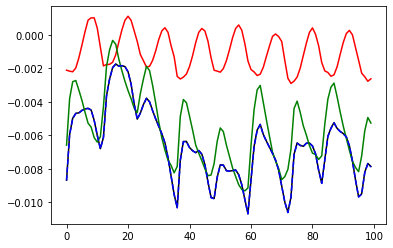

In [98]:
plt.plot(np.arange(0,100,1), rho_anom.isel(time=slice(0,100)), color='black')
plt.plot(np.arange(0,100,1), rho_temp.isel(time=slice(0,100)), color='red')
plt.plot(np.arange(0,100,1), rho_salt.isel(time=slice(0,100))/1000., color='green')
plt.plot(np.arange(0,100,1), rho_temp.isel(time=slice(0,100)) + rho_salt.isel(time=slice(0,100))/1000., color='blue', linestyle='dashed')

In [100]:
rho_all=[]
rho_all.append(rho_anom)

In [101]:
print(rho_all)

[<xarray.DataArray 'RHO' (time: 2412)>
array([-0.00867306, -0.00595344, -0.00497481, ...,  0.00307833,
        0.00233626,  0.00279714])
Coordinates:
  * time     (time) datetime64[ns] 1850-01-16T13:00:00 ... 2050-12-16T12:00:00]


In [ ]:


dat = xr.open_mfdataset(filelist[0], concat_dim='time', preprocess=partial(preprocessor), parallel=True, 
                       chunks={"time":300, "z_t":20, "nlat":120, "nlon":120})

In [54]:
dat = xr.open_mfdataset(filelist[0], concat_dim='time', parallel=True, chunks={"time":300, "z_t":20, "nlat":120, "nlon":120})

In [58]:
print(dat)

<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat: 384, nlon: 320, time: 2412, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_bot: 60, z_w_top: 60)
Coordinates:
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
  * moc_z                   (moc_z) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05
    ULONG                   (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
    TLONG   

In [55]:
test = preprocessor(dat)

In [56]:
print(test)

<xarray.DataArray (time: 2412, nlat: 384, nlon: 320)>
dask.array<truediv, shape=(2412, 384, 320), dtype=float32, chunksize=(300, 120, 120), chunktype=numpy.ndarray>
Coordinates:
    ULONG    (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
    ULAT     (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(120, 120), meta=np.ndarray>
  * time     (time) datetime64[ns] 1850-01-16T13:00:00 ... 2050-12-16T12:00:00
Dimensions without coordinates: nlat, nlon


In [41]:
cluster.close()